# Мудрёная спарсификация
Семинар по спарсификации мы бедм проводить на очень простой и в то же время очень известной задаче из статьи "[Grokking — Generalization beyond overfit](https://arxiv.org/pdf/2201.02177.pdf)", в ней используется трансформер, она вызывает интерес и, наконенец именно на ней можно получить предельные результаты, которые раззадоривают фантазию. Основой для ноутбука послужил код, сделанный [@AbstractDL](https://t.me/abstractDL/274) в его телеграм-канале.

In [21]:
from pathlib import Path
from math import ceil
import torch
from tqdm import tqdm
from types import SimpleNamespace
from typing import Callable, Any
import math
import re
from collections.abc import Iterable
from IPython.display import clear_output
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor

# Dataset
Простые математические операции, выполняемые по модулю. Сложение, вычитание и деление. Из всех трёх наиболее интересно деление. В оригинальной работе в качестве модуля используется 98, но тогда полная спарсификация модели до предельныхз значений займёт до часа, мы возмём модуль поменьше 64, например, и это позволит взять и модель поменьше.

In [3]:
DIVISION_MODULO_OPERATIONS = {
    # Хитрожопый маневр в том, что x делается ответом, а остаток от деления прозведения - одним из вxодных данных.
    # Так что это такая таблицa остатков от деления. Видимо чтобы закономерность была, но была при этом по возможности запутаннее.
    "x/y": lambda x, y, p: (x*y % p, y, x),
}

ALL_MODULO_OPERATIONS = {
    "x+y": lambda x, y, _: (x, y, x + y),
    "x-y": lambda x, y, _: (x, y, x - y),
    **DIVISION_MODULO_OPERATIONS,
}

ALL_OPERATIONS = {
    **ALL_MODULO_OPERATIONS,
}

DEVICE = torch.device("cuda")

def operation_mod_p_data(operation:str, p:int, eq_token: int, op_token:int):
    """
    x◦y (mod p) for 0 <= x < p, 1 <= y < p if operation in DIVISION_MODULO_OPERATIONS
    x◦y (mod p) for 0 <= x, y < p otherwise
    """
    x = torch.arange(0, p)
    y = torch.arange(0 if not operation in DIVISION_MODULO_OPERATIONS else 1, p)
    x, y = torch.cartesian_prod(x, y).T

    eq = torch.ones_like(x) * eq_token
    op = torch.ones_like(x) * op_token

    x, y, labels = ALL_OPERATIONS[operation](x, y, p)

    inputs = torch.stack([x, op, y, eq], dim=1)

    return inputs, labels

def get_data(operation: str, prime: int, training_fraction: float, batch_size: int, seed:int=42):
    inputs, labels = operation_mod_p_data(operation, prime, prime, prime+1)
    dataset = torch.utils.data.TensorDataset(inputs, labels)

    train_size = int(training_fraction * len(dataset))
    val_size = len(dataset) - train_size

    torch.random.manual_seed(seed)
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    batch_size = min(batch_size, ceil(len(dataset) / 2))

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader


## Посмотрим на что похожи исходные данные
При двух разных модулях

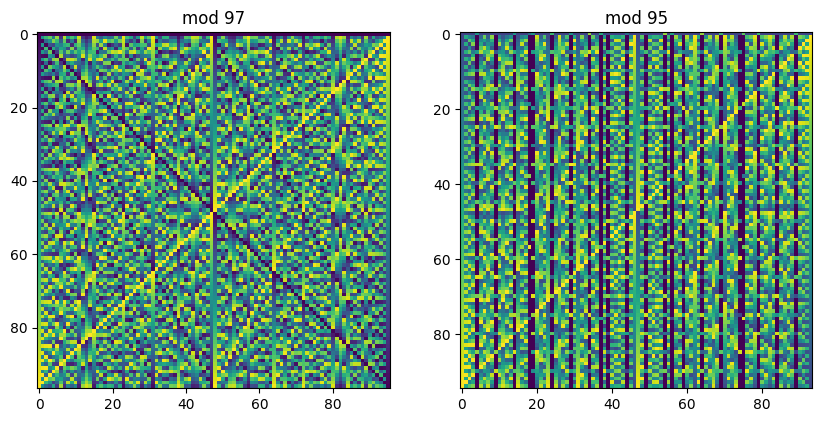

In [4]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
train_loader, val_loader = get_data(operation="x/y", prime=97, training_fraction=.5, batch_size=512)
data = torch.cat([torch.cat([x.view((-1,2,2))[:,:,0],y.view((-1,1))],dim=1) for x,y in train_loader]+
                [torch.cat([x.view((-1,2,2))[:,:,0],y.view((-1,1))],dim=1) for x,y in val_loader], dim=0)
img = torch.ones((data[:,0].max()+1, data[:,1].max()))*-.25
img[data[:,0], data[:,1]-1] = data[:,2]/data[:,2].max()
plt.imshow(img)
plt.title('mod 97')
plt.subplot(1,2,2)
train_loader, val_loader = get_data(operation="x/y", prime=95, training_fraction=.5, batch_size=512)
data = torch.cat([torch.cat([x.view((-1,2,2))[:,:,0],y.view((-1,1))],dim=1) for x,y in train_loader]+
                [torch.cat([x.view((-1,2,2))[:,:,0],y.view((-1,1))],dim=1) for x,y in val_loader], dim=0)
img = torch.ones((data[:,0].max()+1, data[:,1].max()))*-.25
img[data[:,0], data[:,1]-1] = data[:,2]/data[:,2].max()
plt.imshow(img)
plt.title('mod 95')
plt.show()

del train_loader, val_loader, data

Что интересно с этой задачей? Во-первых она ваще не очевидная, во вторых в неё есть очевидные, но совершенно не простые закономерности, которые можно освоить, начиная с очевидной симметрии и глубже к более сложным зависимостям. Ну и, наконец, то что мы будем её решать трансформером - топовой современной архитектурой.

## Model

In [5]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, dim_model: int, n_heads: int):
        super().__init__()

        self.self_attn = nn.MultiheadAttention(dim_model, n_heads)
        self.self_attn_norm = nn.LayerNorm(dim_model)
        self.ffn = nn.Sequential(
            nn.Linear(dim_model, dim_model * 4),
            nn.GELU(),
            nn.Linear(dim_model * 4, dim_model)
        )
        self.ffn_norm = nn.LayerNorm(dim_model)

    def forward(self, x: Tensor):
        attn_mask = torch.full(
            (len(x), len(x)), -float("Inf"), device=x.device, dtype=x.dtype
        )
        attn_mask = torch.triu(attn_mask, diagonal=1)

        a1, _ = self.self_attn(x, x, x, attn_mask=attn_mask)
        a1 = self.self_attn_norm (x + a1)
        a2 = self.ffn(a1)
        a2 = self.ffn_norm(a1 + a2)

        return a2

class Transformer(torch.nn.Module):
    def __init__(self, num_layers: int, dim_model: int, num_heads: int, num_tokens: int, seq_len: int):
        super().__init__()

        self.token_embeddings = nn.Embedding(num_tokens, dim_model)
        self.position_embeddings = nn.Embedding(seq_len, dim_model)
        self.model = nn.Sequential(
            *[DecoderBlock(dim_model, num_heads) for _ in range(num_layers)],
            nn.LayerNorm(dim_model),
            nn.Linear(dim_model, num_tokens)
        )

    def forward(self, inputs: Tensor):
        batch_size, context_len = inputs.shape

        token_embedding = self.token_embeddings(inputs)

        positions = torch.arange(context_len, device=inputs.device).unsqueeze(0).expand(batch_size, -1) # einops.positions = repeat(torch.arange(context_len, device=inputs.device), "p -> b p", b = batch_size)

        position_embedding = self.position_embeddings(positions)

        embedding = token_embedding + position_embedding
        embedding = embedding.permute(1, 0, 2) # einops.rearrange(embedding, 'b s d -> s b d') # (batch, sequence, features), после операции станет (sequence, batch, features)

        return self.model(embedding)


### Инструменты градиента

In [6]:
def evaluate(model, data_loader, device = torch.device('cuda')):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss(reduction='none')
    cnt,correct,loss = 0,0,0.
    with torch.no_grad():
        for batch in data_loader:
            #print('evaluate', batch[0].shape)
            batch = tuple(t.to(device) for t in batch)
            inputs, labels = batch
            output = model(inputs)[-1,:,:]
            cnt += output.size(0)
            batch_correct = (torch.argmax(output, dim=1) == labels)
            batch_loss = criterion(output, labels)
            correct += batch_correct.sum()
            loss += batch_loss.sum()
    return SimpleNamespace(accuracy=correct/cnt, loss=loss/cnt)

def calculate_gradients(model:torch.nn.Module, data_loader:Iterable[tuple[torch.Tensor, torch.Tensor]], device:torch.device = torch.device('cuda')):
    optim = torch.optim.SGD(model.parameters(), 0)
    optim.zero_grad()
    grad = [torch.zeros_like(p) if p.requires_grad_ else None for p in model.parameters()]
    grad_sqr = [torch.zeros_like(p) if p.requires_grad_ else None for p in model.parameters()]
    model.train()
    criterion = torch.nn.CrossEntropyLoss(reduction='sum') # В сильно дискретных форматах данныхз можно уткнуться в потолок точности
    cnt,correct,loss = 0,0,0.
    for batch in data_loader:
        optim.zero_grad()
        inputs, labels = batch[0].to(device), batch[1].to(device)
        cnt += inputs.size(0)
        output = model(inputs)[-1,:,:]
        correct += (torch.argmax(output, dim=1) == labels).sum()
        batch_loss = criterion(output, labels)
        batch_loss.backward()
        loss += batch_loss.detach()
        with torch.no_grad():
            for p,g,s in zip(model.parameters(), grad, grad_sqr):
                if p.requires_grad_:
                    g += p.grad
                    s += p.grad.square()

    return SimpleNamespace(accuracy=(correct/cnt).item(),
                           loss=(loss/cnt).item(),
                           gradients=[g/cnt if g is not None else None for g in grad],
                           gradients_sqr=[g/cnt if g is not None else None for g in grad_sqr],
                           len=cnt)
def GradientSqrToGradientStandart(grad:list[torch.Tensor], grad_sqr:list[torch.Tensor]) -> list[torch.Tensor]:
    return [(gs.sub_(g.square()).sqrt_() if gs is not None else None) for g,gs in zip(grad, grad_sqr)]
class GradientsCollector:
    def __init__(self, model:torch.nn.Module, beta:float=1/1000, collect_std:bool=False):
        self.model = model
        self.steps = 0
        self.beta = beta
        self.gradients = [torch.zeros_like(p) if p.requires_grad else None for p in model.parameters()]
        self.gradients_sqr = [torch.zeros_like(p) if p.requires_grad else None for p in model.parameters()] if collect_std else None

    def collect(self:"GradientsCollector"):
        self.steps = self.steps+1
        b = max(1/self.steps, self.beta)
        a = 1-b
        # Decay the first and second moment running average coefficient
        # exp_avg.lerp_(grad, 1 - beta1)
        # exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
        # В оптимизаторе это делают по другому, возможно так это более эффективно.
        for p,g in zip(self.model.parameters(), self.gradients):
            if (p.grad is None) or (g is None): continue
            g.mul_(a).add_(p.grad, alpha=b)
        if self.gradients_sqr is not None:
            for p,gs in zip(self.model.parameters(), self.gradients_sqr):
                if (p.grad is None) or (g is None): continue
                gs.mul_(a).add_(p.grad.square(), alpha=b)
    def std(self:"GradientsCollector"):
        if self.gradients_sqr is not None:
            return [(grad_sqr - grad.square()).clamp(min=0).sqrt() for grad, grad_sqr in zip(self.gradients, self.gradients_sqr)]
            #for grad, grad_sqr in zip(self.gradients, self.gradients_sqr):
            #    yield (grad_sqr - grad.square()).clamp(min=0).sqrt()
    def state_dict(self:"GradientsCollector")->dict:
        return {"steps":self.steps,
                "beta":self.beta,
                "gradients":[g.cpu().clone() if g is not None else None for g in self.gradients],
                "gradients_sqr":[g.cpu().clone() if g is not None else None for g in self.gradients_sqr] if self.gradients_sqr is not None else None
                }
    def load_state_dict(self:"GradientsCollector", data:dict):
        self.steps = data["steps"]
        self.beta = data["beta"]
        self.gradients = [d.to(p.device) if p is not None else None for p,d in zip(self.gradients, data["gradients"])]
        self.gradients_sqr = [d.to(p.device) if p is not None else None for p,d in zip(self.gradients, data["gradients_sqr"])] if data["gradients_sqr"] is not None else None
    def to(self, target):
        if isinstance(target, torch.nn.Module):
            self.gradients = [g.to(p.device) if g is not None else None for g,p in zip(self.gradients,target.parameters())] if self.gradients is not None else None
            self.gradients_sqr = [g.to(p.device) if g is not None else None for g,p in zip(self.gradients_sqr,target.parameters())] if self.gradients_sqr is not None else None
        else:
            self.gradients = [g.to(target) if g is not None else None for g in self.gradients] if self.gradients is not None else None
            self.gradients_sqr = [g.to(target) if g is not None else None for g in self.gradients_sqr] if self.gradients_sqr is not None else None


## Инструменты пайплайна

In [7]:
class HaltWeights:
    '''Ситуационный класс подпорка - Заморозить обучение тех весов, которые нулевые.'''
    def save_mask(self, model:torch.nn.Module):
        self.mask = [p==0 for p in model.parameters()]
    def applay_mask(self, model:torch.nn.Module):
        with torch.no_grad():
            for p,m in zip(model.parameters(), self.mask):
                p[m] = 0

def resolve_modifiers(model:torch.nn.Module, modifiers:str or dict[str,float] or None=r'^(?!.*_norm\.weight$).*$') -> list[float]:
    r'''По умолчанию игнорить _norm.weight, можно то же сделать через {r'.*_norm\.weight$':None}'''
    resolved = None
    if isinstance(modifiers, str):
        condition = re.compile(modifiers)
        resolved = [1 if condition.match(name) else None for name,param in model.named_parameters()]
    elif modifiers is not None:
        resolved = [1 for name,param in model.named_parameters()]
        for condition,modifier in modifiers.items():
            condition = re.compile(condition)
            for i,(name,param) in enumerate(model.named_parameters()):
                if resolved[i] is not None:
                    if condition.match(name):
                        resolved[i] = resolved[i]*modifier if modifier is not None else None
    return resolved


In [8]:
def mean(data:Iterable):
    return sum(data)/len(data)

def parameters_count(model:torch.nn.Module):
    '''Количество параметров в модели'''
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
def zeros_by_params(model:torch.nn.Module):
    return [(p==0).sum().item() for p in model.parameters()]
def zeros(model:torch.nn.Module):
    return sum([(p==0).sum().item() for p in model.parameters()])
def dead_by_params(model:torch.nn.Module, gradients:GradientsCollector or Iterable[torch.Tensor]):
    return [((p==0)&(g==0)).sum().item() if g is not None else None for p,g in zip(model.parameters(), gradients.gradients if isinstance(gradients, GradientsCollector) else gradients)]
def dead(model:torch.nn.Module, gradients:GradientsCollector or Iterable[torch.Tensor]):
    return sum([((p==0)&(g==0)).sum().item() if g is not None else 0 for p,g in zip(model.parameters(), gradients.gradients if isinstance(gradients, GradientsCollector) else gradients)])


## Инструменты времени и графики

In [9]:
import time

# Инструменты по работе с временем
def time_to_str(value:float):
    ''' Преобразование float в краткую запись количества времени
        Args:
            value (float): Время в секундах
        Returns:
            str: Два самых главных компонента времени
    '''
    if value < 0.5:
        return f"{value*1000:.3f}:ms";
    t = []
    value = round(value)
    if value > 0: t.append(value%60); value = value//60
    if value > 0: t.append(value%60); value = value//60
    if value > 0: t.append(value%24); value = value//24
    if value > 0: t.append(value);
    t = [f'{v:02}{e}' for v,e in zip(t,['s','m','h','d'])]
    return ':'.join(t[-2:][::-1])

class stopwatch:
    ''' Просто класс, упрощающий контроль за временем, чтобы всякие сложные преобразования строк спрятать под капот
        Методы:
            elapsed():float
            progress(current:float, total:float):str
    '''
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self):
        return time.time() - self.start_time
    def progress(self, current, total):
        elapsed = self.elapsed()
        return f"{time_to_str(elapsed)}/{time_to_str(elapsed*total/current)}"
    def __repr__(self):
        return time_to_str(self.elapsed())

def color_by_id(color:int):
    ''' Вынимает цвета по айдишнику из стандартной матплотлибовской таблицы
        Args:
            color (int): Первый цвет в формате #RRGGBB
        Returns:
            str: цвет в формате #RRGGBB
    '''
    if isinstance(color, int):
        colors = mpl.rcParams["axes.prop_cycle"]
        return [c['color'] for c in colors][color % len(colors)]
    return color


# Train Loop

In [10]:
def Config(weight_decay:float=1., **kargs):
    cfg = SimpleNamespace(operation="x/y",
                          training_fraction=0.5,
                          prime=97,
                          device=DEVICE,
                          num_layers=2,
                          dim_model=128,
                          num_heads=4,
                          batch_size=512,
                          learning_rate=1e-3,
                          betas=(0.9, 0.97),
                          weight_decay=weight_decay, # Лучшее значение при котором грокинг начинается ещё до того как оверфитинг дойдёт до конца
                          scheduler_factory = None,
                    )
    for key,value in kargs:
        setattr(cfg, key, value)
    return cfg
config = Config()

In [17]:
def State(config, path:str, model:torch.nn.Module = None, **kargs):
    model:torch.nn.Module = Transformer(
        num_layers=config.num_layers,
        dim_model=config.dim_model,
        num_heads=config.num_heads,
        num_tokens=config.prime + 2,
        seq_len=5
    ).to(DEVICE) if model is None else model
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.learning_rate,
        betas=config.betas,
        eps=1e-5,
        weight_decay=config.weight_decay
    )
    train_loader, val_loader = get_data(operation=config.operation, prime=config.prime, training_fraction=config.training_fraction, batch_size=config.batch_size)
    state = SimpleNamespace(train_loader = train_loader,
                            val_loader = val_loader,
                            path = path,
                            epoch = -1,
                            config = config,
                            model = model,
                            halt = HaltWeights(),
                            optimizer = optimizer,
                            scheduler = config.scheduler_factory(optimizer) if config.scheduler_factory is not None else None,
                            gradients_collector = GradientsCollector(model, beta=1/10, collect_std=True),
                            criterion = torch.nn.CrossEntropyLoss(),
                            lr = [],
                            loss = SimpleNamespace(train = [], eval = []),
                            acc = SimpleNamespace(train = [], eval = []),
                           )
    for key,value in kargs:
        setattr(state, key, value)
    return state
state = State(config, 'itmo/first_run/')


In [18]:
def Prepair(state, num_epochs:int = 3, save_model:bool=False):
    '''Обнуляем скорость обучения и прогреваем оптимизатор, также помещаем во всякие массивы состояния начальные значения'''
    lr_backup = [g['lr'] for g in state.optimizer.param_groups]
    for g in state.optimizer.param_groups: g['lr'] = 0
    for epoch in tqdm(range(num_epochs)):
        state.model.train()
        train_loss,train_acc,train_cnt = 0,0,0
        for inputs, labels in state.train_loader:
            state.optimizer.zero_grad()
            output = state.model(inputs.to(DEVICE))[-1,:,:]
            loss = state.criterion(output, labels.to(DEVICE))
            acc = (torch.argmax(output, dim=1) == labels.to(DEVICE))
            loss.backward()
            state.gradients_collector.collect()
            state.optimizer.step()
            train_loss += loss.detach()*len(labels)
            train_acc += acc.sum()
            train_cnt += len(labels)
    state.halt.save_mask(state.model)
    metrics = evaluate(state.model, state.val_loader)
    for g,b in zip(state.optimizer.param_groups, lr_backup):
        g['lr'] = b
        g['step'] = 0
    state.loss.train.append((train_loss/train_cnt).cpu())
    state.loss.eval.append(metrics.loss.cpu())
    state.acc.train.append((train_acc.to(torch.float)/train_cnt).cpu())
    state.acc.eval.append(metrics.accuracy.cpu())
    Path(state.path).mkdir(parents=True, exist_ok=True)
    if save_model:
        torch.save(state.model.state_dict(), f"{state.path}step{-1:06d}_model.pkl")
Prepair(state)
state.loss, state.acc


100%|██████████| 3/3 [00:00<00:00,  6.55it/s]


(namespace(train=[tensor(4.7728)], eval=[tensor(4.7462)]),
 namespace(train=[tensor(0.0095)], eval=[tensor(0.0103)]))

In [19]:
def chekpoint_folder(state:SimpleNamespace) -> Path:
    path:Path = Path(state.path)/f'chkpt{state.epoch:06d}'
    path.mkdir(parents=True, exist_ok=True)
    return path
def Train(state, epochs:int, period:int=25, *,
          save_checkpoints:bool = True,
          on_before_optimizer_step:list[Callable[[SimpleNamespace],None]]=[],
          on_before_applay_mask:list[Callable[[SimpleNamespace],None]]=[],
          on_after_batch:list[Callable[[SimpleNamespace],None]]=[],
          on_before_epoch_close:list[Callable[[SimpleNamespace],None]]=[],
          on_after_epoch:list[Callable[[SimpleNamespace],None]]=[],
          on_after_period:list[Callable[[SimpleNamespace],None]]=[],
          on_finally:list[Callable[[SimpleNamespace],None]] = []
         ):
        start_time = stopwatch()
        try:
            last_epoch = state.epoch + epochs # Это потому что можно продолжать обучение с места остановки
            for epoch in tqdm(range(state.epoch+1, state.epoch + epochs+1)):
                last = epoch == last_epoch
                train_loss, train_accuracy = [],[]
                state.lr.append(state.optimizer.param_groups[0]['lr'])
                for bi, (X, Y) in enumerate(state.train_loader):
                    Y = Y.to(DEVICE)
                    state.optimizer.zero_grad()
                    logits:torch.Tensor = state.model(X.to(DEVICE))[-1,:,:]
                    acc:torch.Tensor = (torch.argmax(logits, dim=1) == Y).to(torch.float).sum()/logits.size(0)
                    loss:torch.Tensor = state.criterion(logits, Y)
                    loss.backward()
                    state.gradients_collector.collect()
                    for processor in on_before_optimizer_step: processor(state, epoch=epoch, batch_index=bi, accuracy=acc, loss=loss, X=X, Y=Y)
                    state.halt and state.halt.save_mask(state.model)
                    state.optimizer.step()
                    for processor in on_before_applay_mask: processor(state, epoch=epoch, batch_index=bi, accuracy=acc, loss=loss, X=X, Y=Y)
                    state.halt and state.halt.applay_mask(state.model)
                    train_loss.append(loss.detach())
                    train_accuracy.append(acc)
                    for processor in on_after_batch: processor(state, loss=loss, acc=acc, X=X, Y=Y, logits=logits)
                    state.scheduler and state.scheduler.step()
                for processor in on_before_epoch_close: processor(state, train_loss=train_loss, train_accuracy=train_accuracy, epoch=epoch)
                state.loss.train.append(mean(train_loss).cpu())
                state.acc.train.append(mean(train_accuracy).mean().cpu())
                eval_metrics = evaluate(state.model, state.val_loader, DEVICE)
                state.loss.eval.append(eval_metrics.loss.cpu())
                state.acc.eval.append(eval_metrics.accuracy.cpu())
                for processor in on_after_epoch: processor(state, train_loss=train_loss, train_accuracy=train_accuracy, epoch=epoch)
                if (epoch+1)%period==0:
                    for processor in on_after_period: processor(state)
                    if save_checkpoints:
                        torch.save(state.model, chekpoint_folder(state)/'model.pt')
                state.epoch = epoch
            path:Path = Path(state.path)/'last_state.pt'
            path.parent.mkdir(parents=True, exist_ok=True)
            torch.save(state, path)
        except KeyboardInterrupt:
            for processor in on_finally: processor(state, start_time = start_time)
            path:Path = Path(state.path)/'last_state.pt'
            path.parent.mkdir(parents=True, exist_ok=True)
            torch.save(state, path)
if not (Path(state.path)/'state_backup.pt').is_file():
    Train(state, 100)
['acc train',state.acc.train[0],state.acc.train[-1]], ['acc eval',state.acc.eval[0],state.acc.eval[-1]]


100%|██████████| 100/100 [00:20<00:00,  4.90it/s]


(['acc train', tensor(0.0095), tensor(0.9022)],
 ['acc eval', tensor(0.0103), tensor(0.0268)])

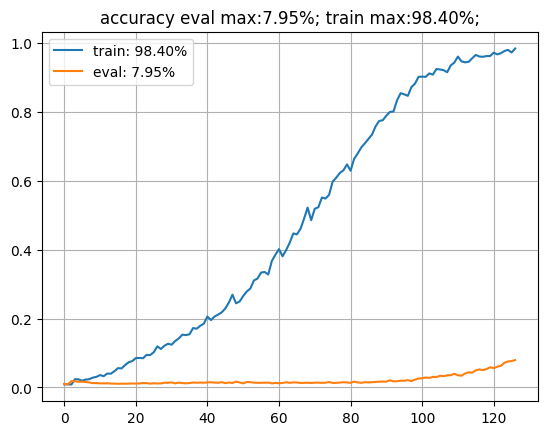

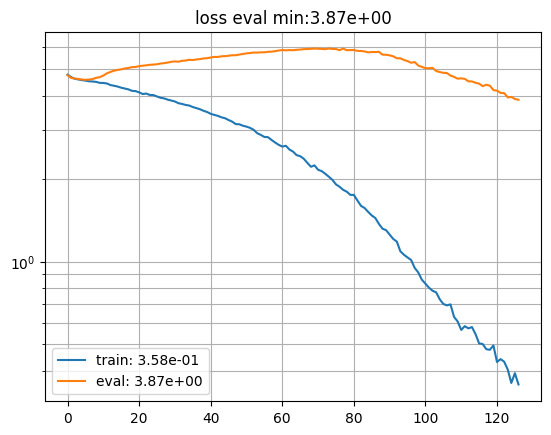

100%|██████████| 25/25 [00:05<00:00,  4.72it/s]


In [22]:
def clear_viewport(*args,**kargs):
    clear_output(True)
def draw_loss(state:SimpleNamespace, *args, save:bool=True, **kargs):
    if 'fig_size' in kargs:
        plt.figure(fig_size=kargs['fig_size'])
    plt.plot(state.loss.train, label=f'train: {state.loss.train[-1]:.2e}')
    plt.plot(state.loss.eval, label=f'eval: {state.loss.eval[-1]:.2e}')
    plt.title(f'loss eval min:{min(state.loss.eval):.2e}')
    plt.yscale('log')
    plt.legend()
    plt.grid(which='both')
    if save:
        plt.savefig(chekpoint_folder(state)/'loss.png')
        plt.show()
def draw_accuracy(state:SimpleNamespace, *args, save:bool=True, **kargs):
    if 'fig_size' in kargs:
        plt.figure(fig_size=kargs['fig_size'])
    plt.plot(state.acc.train, label=f'train: {state.acc.train[-1]:.2%}')
    plt.plot(state.acc.eval, label=f'eval: {state.acc.eval[-1]:.2%}')
    plt.title(f'accuracy eval max:{max(state.acc.eval):.2%}; train max:{max(state.acc.train):.2%};')
    plt.legend()
    plt.grid(which='both')
    if save:
        plt.savefig(chekpoint_folder(state)/'accuracy.png')
        plt.show()
class on_after_every:
    def __init__(self, epochs:int, *children:list[Callable[[SimpleNamespace],None]]):
        self.epochs = epochs
        self.children = children
    def __call__(self, state:SimpleNamespace, *args, **kargs):
        if (state.epoch+1)%self.epochs == 0:
            for child in state.children:
                child(state, *args, **kargs)
def on_KeyboardInterrupt(state:SimpleNamespace, *args, start_time:stopwatch=None, **kargs):
    print(f'KeyboardInterrupt!!! epoch:{state.epoch}; time spended:{start_time};')


BASIC_OUTPUT = [clear_viewport, draw_accuracy, draw_loss]

if not (Path(state.path)/'state_backup.pt').is_file():
    Train(state, 25, on_after_period=BASIC_OUTPUT, on_finally=BASIC_OUTPUT+[on_KeyboardInterrupt])
    torch.save(state, Path(state.path)/'state_backup.pt')
else:
    state = torch.load(Path(state.path)/'state_backup.pt', weights_only=False)


In [23]:
def capture_zeros(state:SimpleNamespace, *args, **kargs):
    if not hasattr(state, 'structure'): state.structure = SimpleNamespace()
    if not hasattr(state.structure, 'zeros'): state.structure.zeros = []
    if not hasattr(state.structure, 'dead'): state.structure.dead = []
    state.structure.zeros.append(zeros(state.model))
    state.structure.dead.append(dead(state.model, state.gradients_collector))
def capture_zeros_structure(state:SimpleNamespace, *args, **kargs):
    if not hasattr(state, 'structure'): state.structure = SimpleNamespace()
    if not hasattr(state.structure, 'zeros_structure'): state.structure.zeros_structure = []
    state.structure.zeros_structure.append((state.epoch, zeros_by_params(state.model)))
capture_zeros(state)
capture_zeros_structure(state)


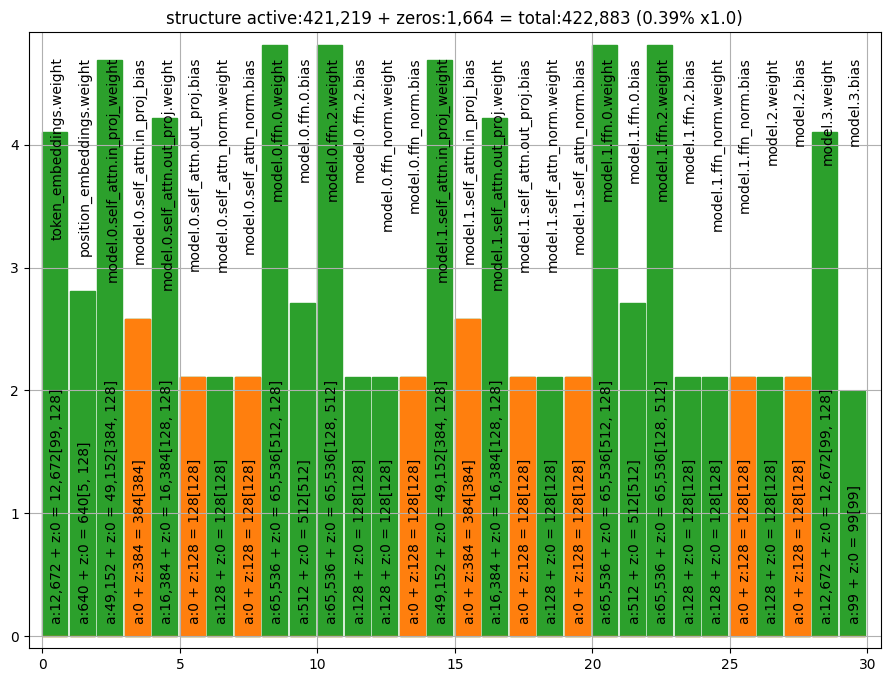

In [25]:
import matplotlib as mpl
import matplotlib.ticker as ticker

def draw_zeros(state:SimpleNamespace, *args, save:bool=True, **kargs):
    def x_formatter(x, pos):
        return f'x{x:.1f}'
    model_params_count = parameters_count(state.model)
    history = len(state.loss.train)
    plt.plot(range(history-len(state.structure.zeros), history), [z/model_params_count for z in state.structure.zeros])
    plt.plot(range(history-len(state.structure.dead), history), [z/model_params_count for z in state.structure.dead], c=color_by_id(1))
    def percent_formatter(x, pos):
        return f'{x:.2%}'
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(percent_formatter))

    сompression_ratio = [model_params_count/(model_params_count-z) for z in state.structure.zeros]

    plt.title(f'{state.structure.zeros[-1]/model_params_count:.2%} x{model_params_count/(model_params_count-state.structure.zeros[-1]):.1f} active:{model_params_count-state.structure.zeros[-1]:,} zeros: {state.structure.zeros[-1]:,} dead:{state.structure.dead[-1]:,}')
    plt.grid()
    plt.twinx(plt.gca())
    plt.plot(range(history-len(state.structure.zeros), history), сompression_ratio, c=color_by_id(2))
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(x_formatter))
    if save:
        plt.savefig(chekpoint_folder(state)/'zeros.png')
        plt.show()

def draw_zeros_struecture(state:SimpleNamespace, *args, save:bool=True, structure:list[int]=None, **kargs):
    if save:
        plt.figure(figsize=(len(list(state.model.parameters()))//3+1, 8))
    numel = [p.numel() for p in state.model.parameters()]
    heights  = [math.log10(n) for n in numel]
    if structure is None:
        structure = zeros_by_params(state.model) # state.structure.zeros_structure[-1][1]

    max_height = max(heights)
    cumulative_total, cumulative_zeros = 0,0
    for i,(total,height,zeros,(name,p)) in enumerate(zip(numel, heights, structure, state.model.named_parameters())):
        cumulative_total += total
        cumulative_zeros += zeros

        plt.gca().add_patch(matplotlib.patches.Rectangle((i,0), .9, height, color = color_by_id(2)))
        plt.gca().add_patch(matplotlib.patches.Rectangle((i,0), .9, height*zeros/total, color = color_by_id(1)))
        plt.text(i+.8, .1, f'a:{total-zeros:,} + z:{zeros:,} = {total:,}{list(p.shape)}', rotation='vertical', horizontalalignment='right', verticalalignment='bottom', color='black', fontsize='medium')
        plt.text(i+.8, max_height-.1, f'{name}', rotation='vertical', horizontalalignment='right', verticalalignment='top', color='black', fontsize='medium')
    plt.xlim((-.5, i+1.5))
    plt.ylim((-0.1, max_height+.1))
    plt.title(f"structure active:{cumulative_total-cumulative_zeros:,} + zeros:{cumulative_zeros:,} = total:{cumulative_total:,} ({cumulative_zeros/cumulative_total:.2%} x{cumulative_total/(cumulative_total-cumulative_zeros):.1f})")
    plt.grid()
    if save:
        plt.savefig(chekpoint_folder(state)/"zeros_structure.png")
        plt.show()
#draw_zeros(state)
draw_zeros_struecture(state)


In [29]:
def capture_shapes_structure(state:SimpleNamespace, *args, **kargs):
    if hasattr(state, 'structure') and not hasattr(state.structure, 'shapes'):
        state.structure.shapes = {n:p.shape for n,p in state.model.named_parameters()}

class ProcessorWrapper:
    def __init__(self, child:Callable[[],None]):
        self.child = child
    def __call__(self, state:SimpleNamespace, *args, **kargs):
        self.child()

def capture_pruning_progress(state, sources:dict[str,Any]):
    if not hasattr(state, 'pruning'): state.pruning = SimpleNamespace()
    if not hasattr(state.pruning, 'iters'): state.pruning.iters = []
    if not hasattr(state.pruning, 'processors'): state.pruning.processors = {}
    state.pruning.iters.append(state.epoch)
    for key,processor in sources.items():
        if key not in state.pruning.processors:
            state.pruning.processors[key] = SimpleNamespace(count=[])
        #if isinstance(processor, DumbDefroster):
        #    state.pruning.processors[key].count.append(processor.restored)
        #    processor.restored = 0
        #else:
        state.pruning.processors[key].count.append(processor.removed)

def draw_pruning(state:SimpleNamespace, *args, save:bool=True, **kargs):
    if not hasattr(state, 'pruning'):
        return
    for key, progress in state.pruning.processors.items():
        plt.plot(state.pruning.iters, progress.count, label=f"{key}:{progress.count[-1]}")
    plt.legend()
    plt.yscale('log')
    plt.title("pruning progress")
    plt.grid(which='both')
    if save:
        plt.savefig(chekpoint_folder(state)/"pruning_progress.png")
        plt.show()


In [28]:
from typing import Iterable
class DumbUnstructuredPruner: # Крайне неэффективная реальзация, зато понятно
    def __init__(self, max_loss_reduction:float, max_count:int=100500, sign:int=+1):
        self.max_count = max_count
        self.max_loss_reduction = max_loss_reduction
        self.sign = sign
        self.trashhold = 5e-9
        self.step = 1.25
        self.removed = 0
    def __call__(self, state:SimpleNamespace, *args, **kargs):
        with torch.no_grad():
          # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
          # Место для вашего творчества
          # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
          return #affected, middle, affected_loss


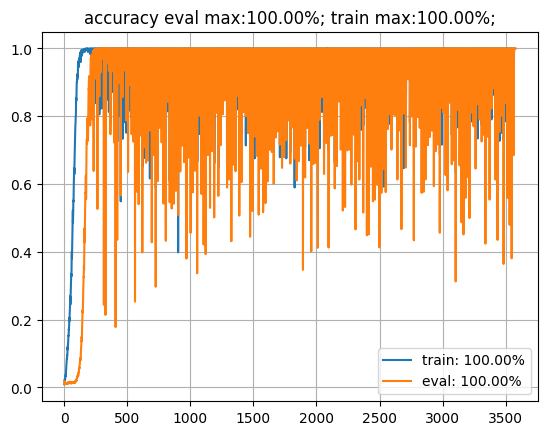

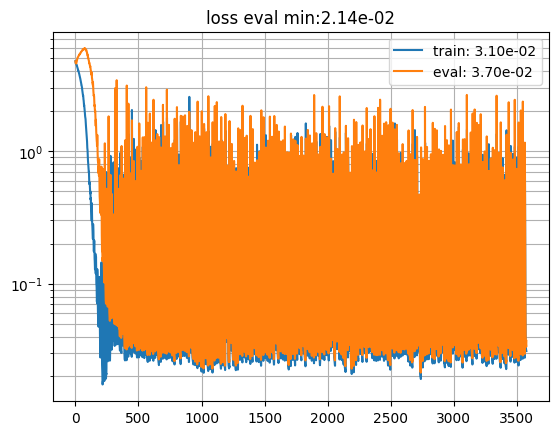

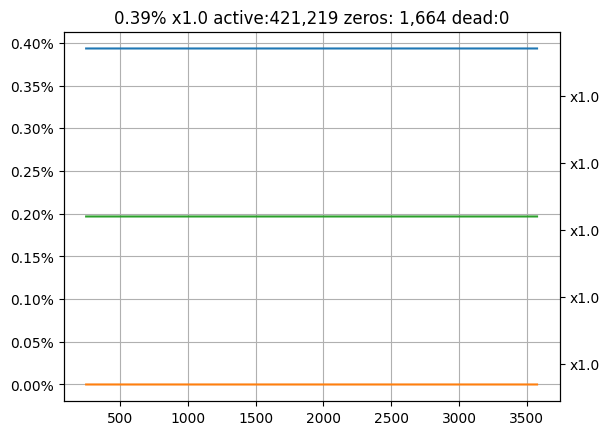

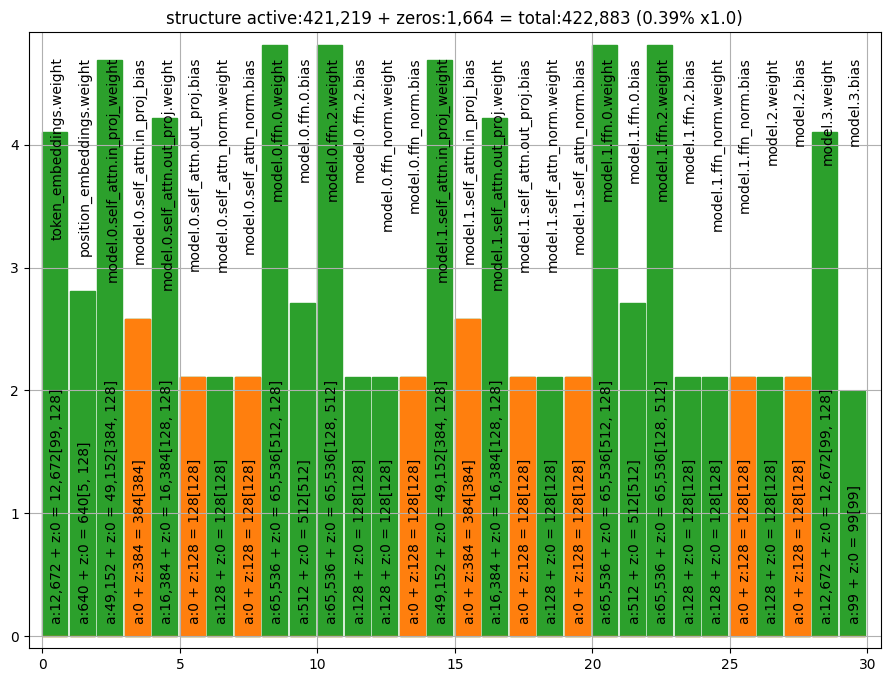

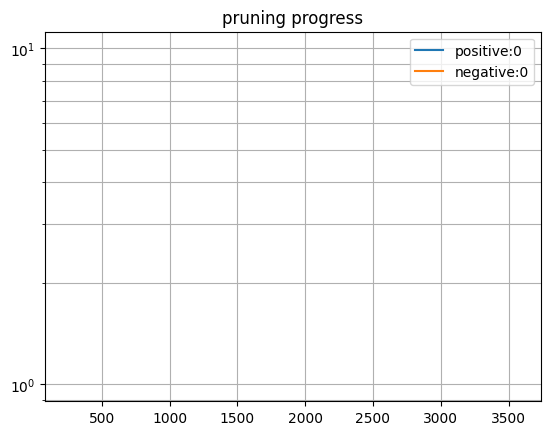

100%|██████████| 3350/3350 [17:15<00:00,  3.23it/s]


In [30]:
Train(state, 100)

pruners = [DumbUnstructuredPruner(1e-5),
           DumbUnstructuredPruner(1e-7, sign=-1)]
#defroster = DumbDefroster(pruners, .5, 0)
Train(state, 3000,
      on_before_applay_mask=[],
      on_after_epoch =
          [capture_shapes_structure,] +
          pruners +
          [   capture_zeros,
              capture_zeros_structure,
              ProcessorWrapper(lambda:capture_pruning_progress(state, {'positive':pruners[0], 'negative':pruners[1]})) # , 'replenish':defroster
          ],
      on_after_period=BASIC_OUTPUT + [
              draw_zeros,
              draw_zeros_struecture,
              draw_pruning,
          ],
      on_finally=BASIC_OUTPUT+[
              draw_zeros,
              draw_zeros_struecture,
              draw_pruning,
          ]+[on_KeyboardInterrupt])
